# Setup and imports

In [40]:
import matplotlib.pyplot as plt
import seaborn           as sb
import pandas            as pd

colours = ["windows blue", "amber", "pale red", "greyish", "faded green", "dusty purple", "orange", "turquoise", "magenta"]

sb.set()
sb.set_style("white")
sb.set_palette(sb.xkcd_palette(colours))

In [1]:
from json     import loads
from numpy    import zeros, ones

# Functions

In [2]:
def left(x,y,gridBounds):
    return (x-1,y) if x > 0 else (x,y)

def right(x,y,gridBounds):
    return (x+1,y) if x+1 < gridBounds[0] else (x,y)

def above(x,y,gridBounds):
    return (x,y-1) if y > 0 else (x,y)

def below(x,y,gridBounds):
    return (x,y+1) if y+1 < gridBounds[1] else (x,y)

In [3]:
# Load the model and client logs from a json file
def loadData(filename):
    with open(filename, "r") as fh:
        data = loads(fh.read())

    # build the world model
    model = data["zones"]

    # determine grid size
    xmax  = ymax = 0
    zones = dict()

    for zone in model:
        zoneID = model[zone]["id"]
        zones[zoneID] = 0
        for cell in model[zone]["cells"]:
            zones[zoneID] += 1
            xmax = max(xmax, cell["x"])
            ymax = max(ymax, cell["y"])

    # represent the cells in a numpy array
    gridBounds = (xmax+1, ymax+1)
    gridSize   = (xmax+1)*(ymax+1)
    grid       = zeros(gridBounds, dtype=object)

    for zone in model:
        zoneID = model[zone]["id"]
        for cell in model[zone]["cells"]:
            grid[cell["x"],cell["y"]] = zoneID

    # load client logs
    logs    = []
    clients = data["clients"]

    for client in clients:
        log = []
        t, zone = 0, clients[client]["positions"][0]
        log.append(dict(timestamp=t, zone=zone))
        for position in clients[client]["positions"]:
            t += 1
            if position != zone:
                zone = position
                log.append(dict(timestamp=t, zone=zone))
        logs.append(log)

    return dict( grid  = grid
               , zones = zones
               , logs  = logs
               )

In [4]:
# Propagate belief using the prior and probabi
def propagate(prior, p, q):
    posterior = zeros(prior.shape)
    for y in range(prior.shape[1]):
        for x in range(prior.shape[0]):
            posterior[(x,y)] += p * prior[(x,y)]

            neighbours = set()
            if left(x,y,prior.shape) != (x,y):
                neighbours.add(left(x,y,prior.shape))
            if right(x,y,prior.shape) != (x,y):
                neighbours.add(right(x,y,prior.shape))
            if above(x,y,prior.shape) != (x,y):
                neighbours.add(above(x,y,prior.shape))
            if below(x,y,prior.shape) != (x,y):
                neighbours.add(below(x,y,prior.shape))

            for cell in neighbours:
                posterior[cell] += (1-p)/len(neighbours) * prior[(x,y)]
    return posterior

In [59]:
def plotLikelihood(likelihood):
    sb.heatmap(likelihood.T)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [38]:
p = 0.5
threshold = 1/25

In [6]:
data = loadData("data/20x20.json")
grid = data["grid"]
logs = data["logs"]

[DEBUG] Running simulation for client 0
[DEBUG] t=0, zone=zone-1
[INFO ] t=27, zone=zone-2. Zone change ok, likelihood is 0.24

[DEBUG] Running simulation for client 1
[DEBUG] t=0, zone=zone-1
[DEBUG] Running simulation for client 2
[DEBUG] t=0, zone=zone-1
[INFO ] t=3, zone=zone-2. Zone change ok, likelihood is 0.08

[INFO ] t=7, zone=zone-1. Zone change ok, likelihood is 0.27

[INFO ] t=15, zone=zone-2. Zone change ok, likelihood is 0.31

[INFO ] t=22, zone=zone-1. Zone change ok, likelihood is 0.26

[DEBUG] Running simulation for client 3
[DEBUG] t=0, zone=zone-1
[INFO ] t=2, zone=zone-2. Zone change ok, likelihood is 0.06

[INFO ] t=12, zone=zone-1. Zone change ok, likelihood is 0.36

[DEBUG] Running simulation for client 4
[DEBUG] t=0, zone=zone-1
[INFO ] t=5, zone=zone-2. Zone change ok, likelihood is 0.10

[INFO ] t=19, zone=zone-1. Zone change ok, likelihood is 0.34

[DEBUG] Running simulation for client 5
[DEBUG] t=0, zone=zone-2
[INFO ] t=5, zone=zone-1. Zone change ok, likel

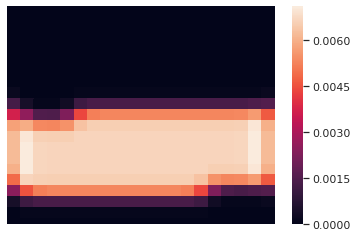

In [61]:
# run simulation for each client
for clientID, log in enumerate(logs):
    print("[DEBUG] Running simulation for client {:}".format(clientID))
    # initialise time and location
    t, zone = log[0]["timestamp"], log[0]["zone"]
    belief = (grid == zone).astype(int)
    belief = belief / belief.sum()
    print("[DEBUG] t={:}, zone={:}".format(t, zone))

    # propagate location through time and check if updates match with estimation
    for entry in log[1:]:
        while t < entry["timestamp"]:
            t += 1
            belief = propagate(belief, p, (1-p)/4)
        newZone = entry["zone"]
        
        if newZone != zone:
            # how likely is it that the client is actually in the new zone?
            likelihood = belief*(grid == newZone).astype(int)
            if likelihood.sum() < threshold:
                print("[INFO ] Anomaly detected! Likelihood of zone={:} at t={:} is {:.2f}!".format(newZone, t, likelihood.sum()))
                plotLikelihood(belief)
            else:
                zone = newZone
                print("[INFO ] t={:}, zone={:}. Zone change ok, likelihood is {:.2f}".format(t, zone, likelihood.sum()))
                belief = likelihood / likelihood.sum()
                
        print()